In [2]:
%reload_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from src.document_preprocessor import RegexTokenizer
from src.indexing import BasicInvertedIndex, Indexer, IndexType
from src.ranker import BM25, Ranker
from src.relevance import run_relevance_tests

In [3]:
STOPWORD_PATH = '../data/stopwords_updated.txt'
DATASET_PATH = '../data/processed_articles_dedup_nsfwtags_sarcasm.csv'
INDEX_PATH = './output/index'

In [4]:
# Load in the stopwords
stopwords = set()
with open(STOPWORD_PATH, 'r', encoding='utf-8') as file:
    for stopword in file:
        stopwords.add(stopword.strip())
f'Stopwords collected {len(stopwords)}'

'Stopwords collected 550'

In [5]:
preprocessor = RegexTokenizer("\w+(?:-\w+)*(?:'[^stmrvld]\w*)*", lowercase=True)

In [6]:
index = BasicInvertedIndex()
index.load(INDEX_PATH)

In [7]:
bm25_scorer = BM25(index)
bm25_ranker = Ranker(index, preprocessor, stopwords, bm25_scorer)

In [8]:
BM25?

Init signature:
BM25(
    index: 'InvertedIndex',
    parameters: 'dict' = {'b': 0.75, 'k1': 1.2, 'k3': 8},
) -> 'None'
Docstring:     
This is the base interface for all the relevance scoring algorithm.
It will take a document and attempt to assign a score to it.
File:           ~/fa24/si650/project/src/ranker.py
Type:           type
Subclasses:     

- Defaults: b = 0.75, k1 = 1.2, k3 = 8

## Ablation study:  `b`

In [9]:
b_values = [0.0, 0.25, 0.5, 0.75, 1.0]
b_maps = []
b_ndcgs = []

ablation_b = {}

for b in b_values:
    print(f"b: {b:.2f}", end=" ")
    
    bm25_scorer = BM25(index, parameters={'b': b, 'k1': 1.2, 'k3': 8})
    bm25_ranker = Ranker(index, preprocessor, stopwords, bm25_scorer)

    metrics = run_relevance_tests("../data/relevance_dev.csv", ranker=bm25_ranker)
    print(f"map: {metrics['map']:.4f}, ndcg: {metrics['ndcg']:.4f}")

    ablation_b[b] = metrics
    b_maps.append(metrics['map'])
    b_ndcgs.append(metrics['ndcg'])

with open('output/ablation_dev_bm25_b.json', 'w') as f:
    json.dump(ablation_b, f)

b: 0.00 map: 0.2225, ndcg: 0.6069
b: 0.25 map: 0.2457, ndcg: 0.6010
b: 0.50 map: 0.2400, ndcg: 0.6090
b: 0.75 map: 0.2114, ndcg: 0.5674
b: 1.00 map: 0.1808, ndcg: 0.5324


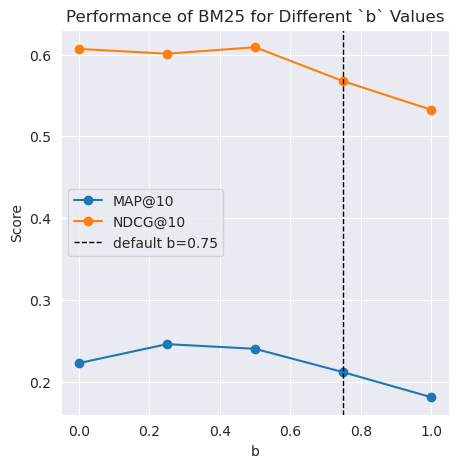

In [10]:
plt.figure(figsize=(5, 5))
plt.plot(b_values, b_maps, label='MAP@10', marker='o')
plt.plot(b_values, b_ndcgs, label='NDCG@10', marker='o')
plt.title('Performance of BM25 for Different `b` Values')
plt.xlabel('b')
plt.ylabel('Score')
plt.axvline(x=0.75, color='k', linestyle='--', linewidth=1, label='default b=0.75')
plt.legend()
plt.show()

## Ablation study:  `k1`

In [11]:
k1_values = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
k1_maps = []
k1_ndcgs = []

ablation_k1 = {}

for k1 in k1_values:
    print(f"k1: {k1:.2f}", end=" ")
    
    bm25_scorer = BM25(index, parameters={'b': 0.75, 'k1': k1, 'k3': 8})
    bm25_ranker = Ranker(index, preprocessor, stopwords, bm25_scorer)

    metrics = run_relevance_tests("../data/relevance_dev.csv", ranker=bm25_ranker)
    print(f"map: {metrics['map']:.4f}, ndcg: {metrics['ndcg']:.4f}")

    ablation_k1[k1] = metrics
    k1_maps.append(metrics['map'])
    k1_ndcgs.append(metrics['ndcg'])

with open('output/ablation_dev_bm25_k1.json', 'w') as f:
    json.dump(ablation_k1, f)

k1: 0.00 map: 0.2051, ndcg: 0.6491
k1: 0.50 map: 0.2204, ndcg: 0.5895
k1: 1.00 map: 0.2187, ndcg: 0.5759
k1: 1.50 map: 0.2041, ndcg: 0.5627
k1: 2.00 map: 0.1924, ndcg: 0.5519
k1: 2.50 map: 0.1906, ndcg: 0.5538
k1: 3.00 map: 0.1773, ndcg: 0.5419


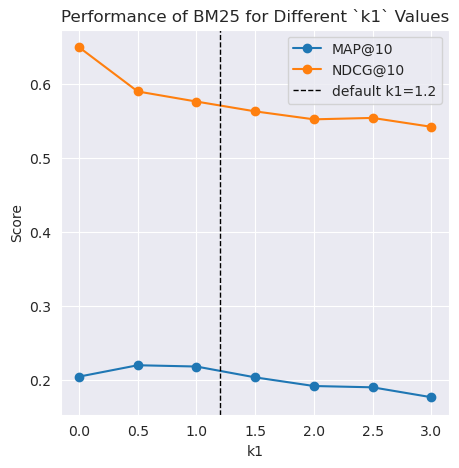

In [12]:
plt.figure(figsize=(5, 5))
plt.plot(k1_values, k1_maps, label='MAP@10', marker='o')
plt.plot(k1_values, k1_ndcgs, label='NDCG@10', marker='o')
plt.title('Performance of BM25 for Different `k1` Values')
plt.xlabel('k1')
plt.ylabel('Score')
plt.axvline(x=1.2, color='k', linestyle='--', linewidth=1, label='default k1=1.2')
plt.legend()
plt.show()

## Combined

In [13]:
b_values = [0.0, 0.25, 0.5, 0.75, 1.0]
k1_values = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

maps = []
ndcgs = []

ablation_both = {}

for b in b_values:
    for k1 in k1_values:
        print(f"b: {b:.2f}, k1: {k1:.2f}", end=" ")
        
        bm25_scorer = BM25(index, parameters={'b': b, 'k1': k1, 'k3': 8})
        bm25_ranker = Ranker(index, preprocessor, stopwords, bm25_scorer)
    
        metrics = run_relevance_tests("../data/relevance_dev.csv", ranker=bm25_ranker)
        print(f"map: {metrics['map']:.4f}, ndcg: {metrics['ndcg']:.4f}")
    
        ablation_both[f"{b}_{k1}"] = metrics
        maps.append(metrics['map'])
        ndcgs.append(metrics['ndcg'])

with open('output/ablation_dev_bm25_b_k1.json', 'w') as f:
    json.dump(ablation_both, f)

b: 0.00, k1: 0.00 map: 0.2051, ndcg: 0.6491
b: 0.00, k1: 0.50 map: 0.2316, ndcg: 0.6263
b: 0.00, k1: 1.00 map: 0.2225, ndcg: 0.6088
b: 0.00, k1: 1.50 map: 0.2214, ndcg: 0.6081
b: 0.00, k1: 2.00 map: 0.2062, ndcg: 0.5967
b: 0.00, k1: 2.50 map: 0.2075, ndcg: 0.5963
b: 0.00, k1: 3.00 map: 0.2048, ndcg: 0.5960
b: 0.25, k1: 0.00 map: 0.2051, ndcg: 0.6491
b: 0.25, k1: 0.50 map: 0.2463, ndcg: 0.6053
b: 0.25, k1: 1.00 map: 0.2502, ndcg: 0.6042
b: 0.25, k1: 1.50 map: 0.2411, ndcg: 0.5945
b: 0.25, k1: 2.00 map: 0.2344, ndcg: 0.5883
b: 0.25, k1: 2.50 map: 0.2314, ndcg: 0.5874
b: 0.25, k1: 3.00 map: 0.2308, ndcg: 0.5826
b: 0.50, k1: 0.00 map: 0.2051, ndcg: 0.6491
b: 0.50, k1: 0.50 map: 0.2423, ndcg: 0.6053
b: 0.50, k1: 1.00 map: 0.2385, ndcg: 0.6088
b: 0.50, k1: 1.50 map: 0.2304, ndcg: 0.5999
b: 0.50, k1: 2.00 map: 0.2241, ndcg: 0.5959
b: 0.50, k1: 2.50 map: 0.2225, ndcg: 0.5937
b: 0.50, k1: 3.00 map: 0.2129, ndcg: 0.5846
b: 0.75, k1: 0.00 map: 0.2051, ndcg: 0.6491
b: 0.75, k1: 0.50 map: 0.2204, n

Best: 0.0_0.0


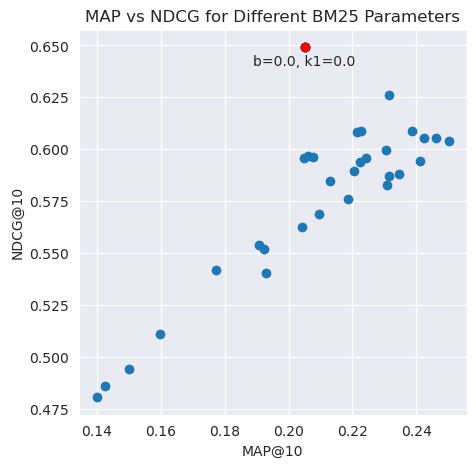

In [28]:
# Identify optimal based on distance from origin
distances = np.sqrt(np.array(maps)**2 + np.array(ndcgs)**2)
best_index = np.argmax(distances)
combinations = list(ablation_both.keys())
print("Best:", combinations[best_index])

plt.figure(figsize=(5, 5))
plt.scatter(maps, ndcgs, marker='o')
plt.scatter(maps[best_index], ndcgs[best_index], c='r', marker='o', label='Best Parameters')
plt.annotate(f'b={b_values[best_index]}, k1={k1_values[best_index]}', 
             (maps[best_index], ndcgs[best_index]), 
             textcoords="offset points", xytext=(0,-13), ha='center')
plt.title('MAP vs NDCG for Different BM25 Parameters')
plt.xlabel('MAP@10')
plt.ylabel('NDCG@10')
plt.show()

# Evaluation

## Defaults

In [34]:
# b = 0.75
# k1 = 1.2

bm25_scorer = BM25(index)
bm25_ranker = Ranker(index, preprocessor, stopwords, bm25_scorer)

In [35]:
metrics_test_default = run_relevance_tests("../data/relevance_test.csv", ranker=bm25_ranker)
metrics_test_default['map'], metrics_test_default['ndcg']

(0.25966625966625967, 0.4824286856440679)

## Tuned

In [38]:
b = 0.0
k1 = 0.0

bm25_scorer = BM25(index, parameters={'b': b, 'k1': k1, 'k3': 8})
bm25_ranker = Ranker(index, preprocessor, stopwords, bm25_scorer)

In [39]:
metrics_test_tuned = run_relevance_tests("../data/relevance_test.csv", ranker=bm25_ranker)
metrics_test_tuned['map'], metrics_test_tuned['ndcg']

(0.2500742775742776, 0.5525818997526951)

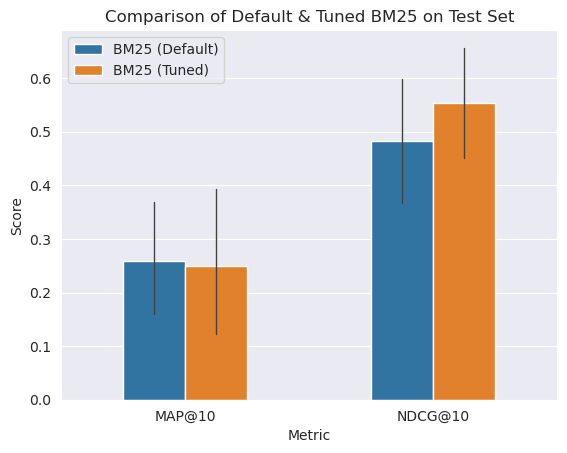

In [44]:
metrics = {
    "BM25 (Default)": metrics_test_default,
    "BM25 (Tuned)": metrics_test_tuned,
}

metrics_df = []
for ranker, metrics in metrics.items():
    metrics_df.append({
        "ranker": ranker, "metric": "MAP@10", 
        "mean_score": metrics["map"], "scores": metrics["map_list"]
    })
    metrics_df.append({
        "ranker": ranker, "metric": "NDCG@10", 
        "mean_score": metrics["ndcg"], "scores": metrics["ndcg_list"]
    })
    
metrics_df = pd.DataFrame(metrics_df)
metrics_df_long = metrics_df.drop("mean_score", axis=1).explode("scores")

sns.barplot(data=metrics_df_long, x="metric", y="scores", hue="ranker", 
            estimator='mean', errorbar=('ci', 95), width=0.5, errwidth=1)

plt.title("Comparison of Default & Tuned BM25 on Test Set")
plt.legend(title="")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.show()